In [135]:
import cv2
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras




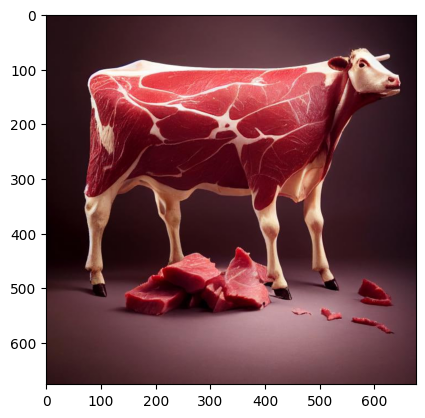

In [136]:
I_o=cv2.imread("kruwsko.png")
I_o = cv2.cvtColor(I_o,cv2.COLOR_BGR2RGB)
plt.imshow(I_o)


In [137]:
I=I_o/255
I_gray = np.zeros((I.shape[0],I.shape[1]))

In [138]:
for y in range(I.shape[0]):
  for x in range(I.shape[1]):
    # NTSC fromula
    I_gray[y][x] = 0.299 * I[y][x][0] + 0.587 * I[y][x][1] + 0.114* I[y][x][2]

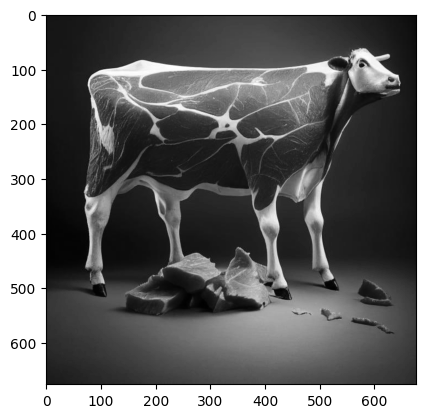

In [139]:
plt.imshow(I_gray,"gray")

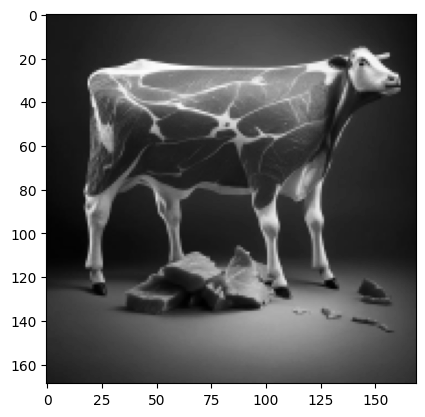

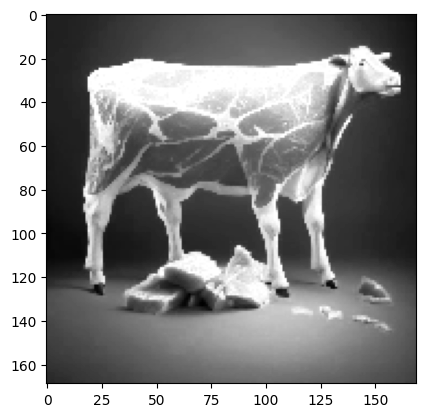

In [140]:
def pooling(I, size, _type):
  if I.shape[0] % size != 0 or I.shape[1] % size != 0:
    print("Kernel size error!")
    return

  I_pooled = np.zeros((int(I.shape[0]/size), int(I.shape[1]/size)))
  for y in range(I_pooled.shape[0]):
    for x in range(I_pooled.shape[1]):
      window = I[y*4:y*4+4,x*4:x*4+4]
      if _type == "max":
        I_pooled[y][x] = np.max(window)
      elif _type == "avg":
        I_pooled[y][x] = np.average(window)
  return I_pooled

I_avg = pooling(I,4,"avg")
I_max = pooling(I,4,"max")
plt.imshow(I_avg,"gray")
plt.show()
plt.imshow(I_max,"gray")
plt.show()


  
  

(169, 169)

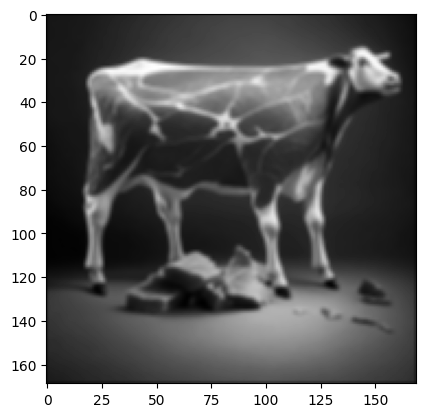

In [141]:
def convolution(I, kernel):

  I_conv = np.zeros(I.shape)
  h = kernel.shape[0]//2
  I_pad = np.pad(I, h)

  
  for y in range(h, I.shape[0]+h):
    for x in range(h, I.shape[1]+h):
       window = I_pad[y-h:y+h+1, x-h:x+h+1]
       I_conv[y-h][x-h] = np.sum(window*kernel)
  return I_conv

def fgaussian(size, sigma):
    h = size//2
    x, y = np.mgrid[-h:h+1, -h:h+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g / g.sum()

def gauss(I,size,sigma):
  gauss_kernel = fgaussian(size,sigma)
  return convolution(I, gauss_kernel)

I_gauss = gauss(I_avg,3,1)
plt.imshow(I_gauss,"gray")

I_gauss.shape


In [142]:
def gradient(I):
  k_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32)
  k_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
  
  I_x = convolution(I,k_x)
  I_y = convolution(I,k_y)

  G = np.sqrt(np.square(I_y)+np.square(I_x))
  G = G/ G.max() * 255
  theta = np.arctan2(I_y, I_x)

  return (G, theta)

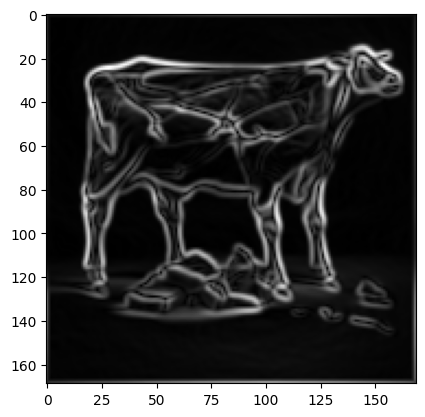

In [143]:

G, theta = gradient(I_gauss)
plt.imshow(G,"gray")


In [144]:
def non_max_suppression(img, D):
  # img = np.pad(I,1)
  M, N = img.shape
  Z = np.zeros((M, N), dtype=np.int32)
  angle = D * 180. / np.pi
  angle[angle < 0] += 180
  for i in range(1, M-1):
    for j in range(1, N-1):
      try:
        q = 255
        r = 255
      #angle 0
        if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
          q = img[i, j+1]
          r = img[i, j-1]
        #angle 45
        elif (22.5 <= angle[i, j] < 67.5):
          q = img[i+1, j-1]
          r = img[i-1, j+1]
        #angle 90
        elif (67.5 <= angle[i, j] < 112.5):
          q = img[i+1, j]
          r = img[i-1, j]
        #angle 135
        elif (112.5 <= angle[i, j] < 157.5):
          q = img[i-1, j-1]
          r = img[i+1, j+1]
        if (img[i, j] >= q) and (img[i, j] >= r):
          Z[i, j] = img[i, j]
        else:
          Z[i, j] = 0
      except IndexError as e:
        pass
  return Z


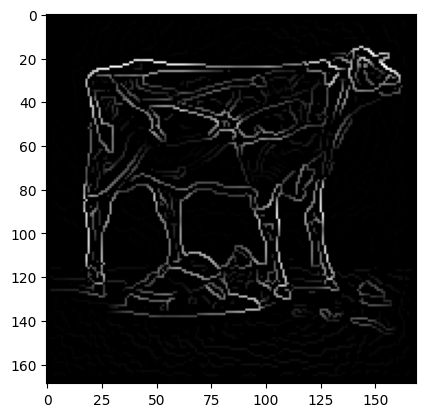

In [145]:
I_nms = non_max_suppression(G, theta)
plt.imshow(I_nms,"gray")

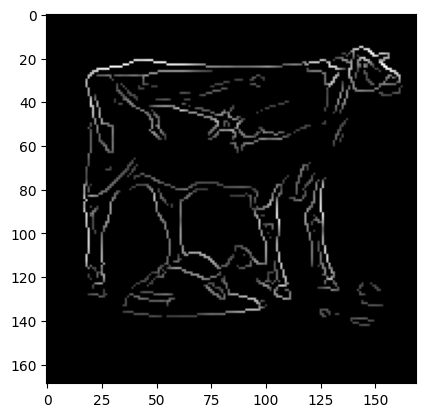

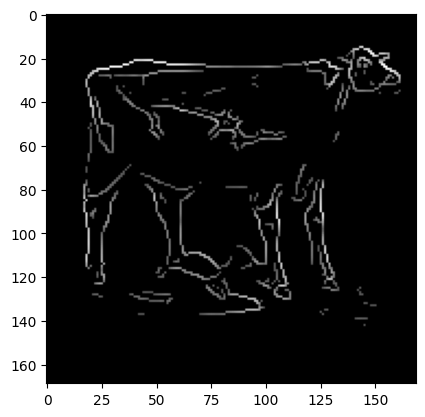

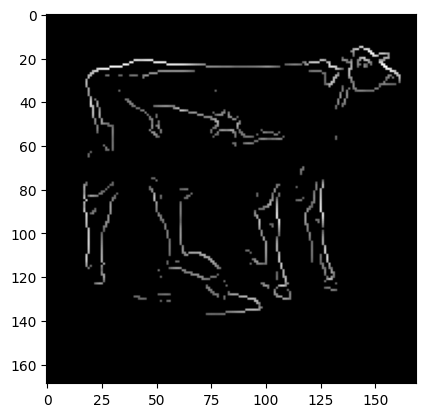

In [146]:
ReLU_60 = keras.layers.ReLU(threshold=60)
I_rel_60 = ReLU_60(I_nms)
plt.imshow(I_rel_60, "gray")
plt.show()
ReLU_80 = keras.layers.ReLU(threshold=80)
I_rel_80 = ReLU_80(I_nms)
plt.imshow(I_rel_80, "gray")
plt.show()
ReLU_100 = keras.layers.ReLU(threshold=100)
I_rel_100 = ReLU_100(I_nms)
plt.imshow(I_rel_100, "gray")
plt.show()


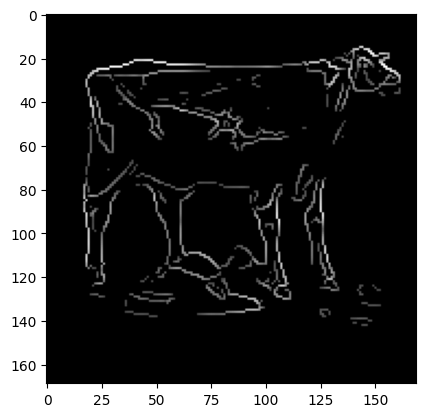

In [147]:
ReLU_70 = keras.layers.ReLU(threshold=70)
I_rel_70 = ReLU_70(I_nms)
plt.imshow(I_rel_70, "gray")
plt.show()


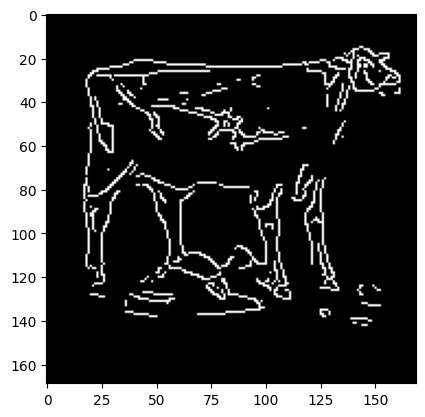

In [155]:
I_edges = np.where(I_rel_70 > 0, 255, 0)
plt.imshow(I_edges, "gray")


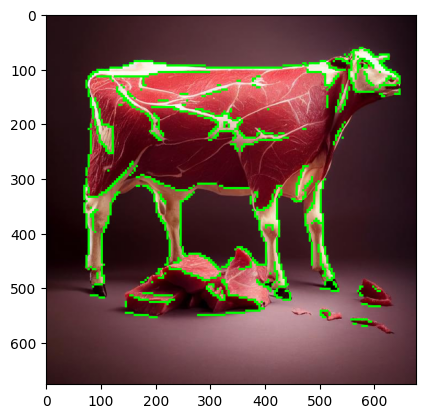

In [156]:
def draw_on_original(I_o, I_edges):
  I_edges = cv2.resize(
      I_edges.astype(np.uint8), (I_o.shape[0], I_o.shape[1]), interpolation=cv2.INTER_AREA)
  for y in range(I_o.shape[0]):
    for x in range(I_o.shape[1]):
      if I_edges[y][x]:
        I_o[y][x]=[0,255,0]
        
  return I_o


I_finnal = draw_on_original(I_o, I_edges)
plt.imshow(I_finnal, "gray")


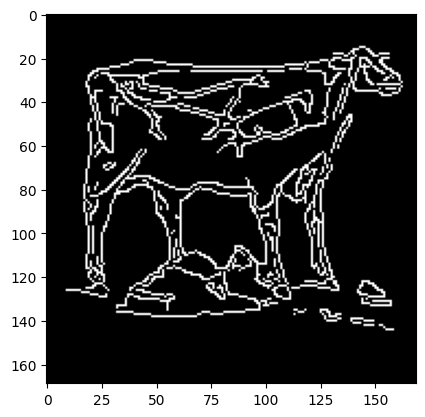

In [157]:
I_cv2Canny = cv2.Canny((I_avg*255).astype(np.uint8), 100, 200, None, 3, 1)
plt.imshow(I_cv2Canny,"gray")